In [10]:
from imdb import IMDb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
from PIL import Image  
import requests, gzip, urllib.request

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly_express as px
import statsmodels.api as sm

In [2]:
baseURL = "https://datasets.imdbws.com/"
filename = "title.ratings.tsv.gz"
outFilePath = 'files/title.ratings.csv'

response = urllib.request.urlopen(baseURL + filename)
with open(outFilePath, 'wb') as outfile:
    outfile.write(gzip.decompress(response.read()))

In [3]:
ratings = pd.read_csv('files/title.ratings.csv', delimiter='\t')
ratings = ratings.set_index(['tconst'])

In [4]:
# create an instance of the IMDb class
imdb = IMDb()

0 tv series The Office
2005


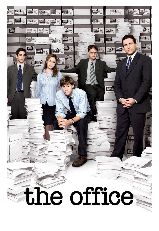

1 tv series The Office
2001


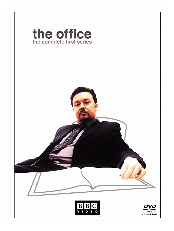

2 tv series The Office
2019


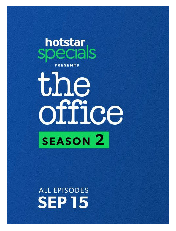

In [5]:
search = 'The Office'
results = imdb.search_movie(search)


for i in range(len(results[:3])):
        
    if results[i]['kind'] == 'tv series':
        print(i, results[i]['kind'], results[i]['title'])
        try:
            print(results[i]['year'])
        except:
            pass
        # creating a object  
        url = results[i]['full-size cover url']

        response = requests.get(url, stream=True)
        img = Image.open(response.raw)

        plt.imshow(img)
        plt.axis('off')
        plt.show()

In [6]:
show = results[0]

try:
    imdb.update(show, info = ['episodes'])
except:
    print("Error 404- Show Episodes not found")

In [7]:
class show_series():
    def __init__(self, show):
        self.show = show

    def create_df(self):
        season, episode, title, year, series, code = [], [], [], [], [], []
        for x in self.show['episodes'].keys():
            for y in self.show['episodes'][x].keys():
                thing = self.show['episodes'][x][y]
                try:
                    year.append(thing['year'])
                    title.append(thing['title'])
                    series.append(self.show['title'])
                    code.append("tt" + imdb.get_imdbID(thing))
                    season.append(x)
                    episode.append(y)
                except:
                    pass
        df_dict = {'season':season, 'episode':episode, 'title':title, 'year':year, 'series':series, 'code':code}
        df = pd.DataFrame(df_dict).sort_values(by=['season', 'episode']).reset_index(drop=True)
        df.index += 1
        df['EpisodeNum'] = df.index
        self.df = self.get_ratings(df)
    
    def try_catch_rating(self, x):
        try:
            return ratings.loc[x, :].values
        except:
            return np.nan
        
    def get_ratings(self, df):
        df['rating'] = df['code'].apply(lambda x: self.try_catch_rating(x))
        df.dropna(inplace = True)
        df = df[df['rating'].apply(lambda x: len(x)) > 0]
        df['votes'] = df['rating'].apply(lambda x: x[1])
        df['rating'] = df['rating'].apply(lambda x: x[0])
        return df
    
    def calc_outliers(self, column = 'rating', sd = 2):
        groups = self.df.groupby('season')[column]
        quan = int(float(sd)/2)
        groups_quan_lower = groups.transform(lambda x: np.percentile(x, quan))
        groups_quan_upper = groups.transform(lambda x: np.percentile(x, 100-quan))
        self.df['outlier'] = self.df[column].between(groups_quan_lower, groups_quan_upper)
        self.df['outlier'] = [ True if x == False else False for x in self.df['outlier'] ]

In [8]:
show_obj = show_series(show)
show_obj.create_df()
show_obj.calc_outliers(sd = 20)

In [9]:
df = show_obj.df
df['combined_labs'] = df['title'] + "\nS " + df['season'].astype(str) + " | E " + df['episode'].astype(str)
outlier_index = df[df['outlier']==True].index.tolist()
df

,season,episode,title,year,series,code,EpisodeNum,rating,votes,outlier,combined_labs
1,1,1,Pilot,2005,The Office,tt0664521,1,7.5,4722.0,True,Pilot\nS 1 | E 1
2,1,2,Diversity Day,2005,The Office,tt0664514,2,8.3,4587.0,False,Diversity Day\nS 1 | E 2
3,1,3,Health Care,2005,The Office,tt0664517,3,7.8,3856.0,False,Health Care\nS 1 | E 3
4,1,4,The Alliance,2005,The Office,tt0664523,4,8.1,3752.0,False,The Alliance\nS 1 | E 4
5,1,5,Basketball,2005,The Office,tt0664510,5,8.4,4104.0,True,Basketball\nS 1 | E 5
...,...,...,...,...,...,...,...,...,...,...,...
184,9,19,Stairmageddon,2013,The Office,tt2669736,184,8.0,1869.0,False,Stairmageddon\nS 9 | E 19
185,9,20,Paper Airplane,2013,The Office,tt2669744,185,8.0,1881.0,False,Paper Airplane\nS 9 | E 20
186,9,21,Livin' the Dream,2013,The Office,tt2876480,186,9.0,2645.0,True,Livin' the Dream\nS 9 | E 21
187,9,22,A.A.R.M.,2013,The Office,tt2669740,187,9.5,3673.0,True,A.A.R.M.\nS 9 | E 22


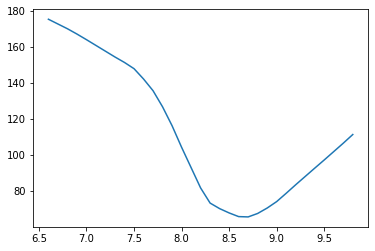

In [15]:
lowess = sm.nonparametric.lowess
z = lowess(df['EpisodeNum'], df['rating'])
plt.plot(z[:,0], z[:,1])

C:\Users\calla\Anaconda3\envs\pyMain\lib\site-packages\plotnine\stats\smoothers.py:168: PlotnineWarning:

Confidence intervals are not yet implementedfor lowess smoothings.



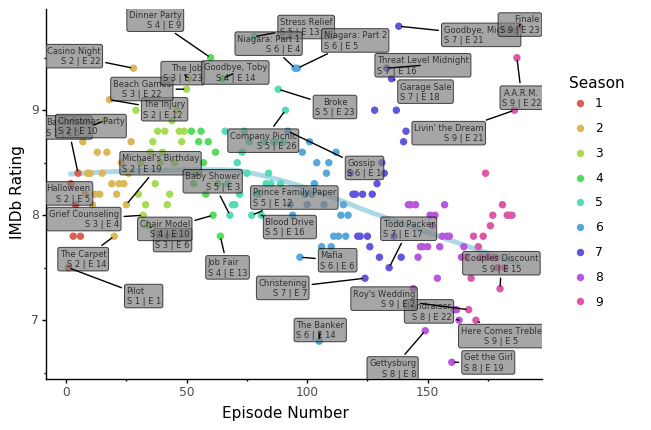

<ggplot: (-9223371868709813824)>

In [38]:
plot = (ggplot(df, aes(y='rating', x=df.index.tolist()))
    + geom_smooth(color='lightblue', size = 2)
    + geom_point(aes(color = 'factor(season)'), size = 2)
    + geom_label(aes(x = outlier_index,
                    y = df[df['outlier']==True]['rating'].values,
                    label = 'combined_labs'),
                data = df[df['outlier']==True], size = 6, show_legend = False, alpha = .7, fill = 'gray',
                adjust_text={'expand_points':(1.5, 1.5), 'expand_text':(2, 2), 'arrowprops': {'arrowstyle': '-'}})
    + labs(x = 'Episode Number', y = 'IMDb Rating', color = "Season")
    + theme_classic())
plot

In [46]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

colors = {
    'background': '#111111',
    'text': '#7FDBFF'
}

app.layout = html.Div(style={'backgroundColor': colors['background']}, children=[
    html.H1(
        children='IMDb TV Series Score',
        style={
            'textAlign': 'center',
            'color': colors['text']
        }
    ),
    
    html.Div(style={'textAlign': 'center','color': colors['text']}, children=[
        dcc.RadioItems(
                id='yaxis',
                options=[{'label': i, 'value': i} for i in ['Rating', 'Votes']],
                value='Rating',
                labelStyle={'display': 'inline-block'}
            )
    ]),
    
    html.Div([
        dcc.Graph(id='indicator-graphic')
    ])
])
    
@app.callback(
    Output('indicator-graphic', 'figure'),
    [Input('yaxis', 'value')])
def update_graph(yaxis):
    df["season"] = df["season"].astype(str)
    fig = px.scatter(
        df,
        x = 'EpisodeNum',
        y = yaxis.lower(),
        color="season",
        trendline = 'ols', 
        hover_name = 'combined_labs',
        opacity=0.7
    )
    
    fig.update_traces(marker=dict(size=15,
                                  line=dict(width=2,
                                            color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.update_layout(
        xaxis={
            'title':'Episode Number'
            },
            yaxis={'title':'IMDb Rating'},
            margin={'l': 40, 'b': 40, 't': 10, 'r': 10},
            legend={'x': 0, 'y': 1},
            hovermode='closest',
            plot_bgcolor = colors['background'],
            paper_bgcolor = colors['background'],
            font = {
                'color': colors['text']
            })
    fig.update_layout(legend_orientation="h",
                     legend=dict(x=-.1, y=1.2))
    fig.update_xaxes(showspikes=True)    
    return fig

if __name__ == '__main__':
    app.run_server(debug=True, use_reloader = False)

Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Running on http://127.0.0.1:8050/
Debugger PIN: 193-941-911
Debugger PIN: 193-941-911
Debugger PIN: 193-941-911
Debu

In [47]:
from dash_1

3